# Assignment #4


Vision Transformer

---



# 1. Batch Normalization

Training a deep neural network is a tricky process. Many techniques have already been proposed for more stable training and faster convergence. Most of these techniques either change the model architecture or improve the training algorithm. Batch normalization belongs to the former group. The method was introduced in 2015 and achieved state-of-the-art in ImageNet,  a well-known image classification benchmark.

## 1.1 Definition

We generally normalize the inputs of a neural network to speed up the convergence. So if the "normalization" works, why not try it on the activation values? How can we improve training by normalizing the values of intermediate layers?

Here is an intermediate layer $l$ in some neural network:

<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg03_assets/01_intermediate_layer.jpg" width="500"/></p>




The general idea is to train layer $l$ faster by normalizing its input. By the layer $l$ we simply mean weigth matrices $W^{l}$, $b^{l}$ and by the input we mean previous layer's activations $a^{l-1}$. For the sake of simplicity, let us change our notation. Instead of normalizing the input of layer $l$, we would like to normalize the output so that the next layers will receive normalized values from our layer. It has the same effect, but it will make the equations much cleaner.

In practice, we do not normalize the output (the activations). Instead, we do the normalization on the weighted sum of inputs $Z^{l}$ just before applying the activation function ($Z^l = xW^l+b^l$).



## 1.2 The formula

Assume we want some variable $x$ to have normalized values, the only way to do that is to collect all of its values and calculate the mean and variance in order to create a normalized version of $x$. This is a fairly reasonable solution, and we use it to normalize the neural network's input. Now imagine the goal is to normalize some intermediate values in a deep neural network; Collecting values of some intermediate point in a neural network is almost impossible since the training algorithm can change them entirely. To overcome this issue, we can collect them over a mini-batch.  It will give us an estimated version of the mean and variance. This is why it is called Batch Normalization. Here is the detailed algorithm:

Given values of $x$ over a mini-batch $\mathcal{B} = \{x_1, .., x_m\}$ :

$$
\mu _\mathcal{B} = \frac{1}{m} \sum^{m}_{i=1} x_i  \ \ \ \ \ \text{(mini-batch mean)}
\\
\sigma^2 _\mathcal{B} = \frac{1}{m} \sum^{m}_{i=1} (x_i-\mu _\mathcal{B})
\ \ \ \ \ \text{(mini-batch variance)}
\\
x^{norm}_i = \frac{x_i - \mu _\mathcal{B}}{\sqrt{\sigma^2 _\mathcal{B} + \epsilon}} \ \ \ \ \ \text{(normalize)}
\\
\hat{x}_i =\gamma x^{norm}_i+\beta  \ \ \ \ \ \text{(scale and shift)}
\\
\mathrm{BN(\mathcal{B}, \gamma, \beta}) = \{\hat{x}_1, ..., \hat{x}_m\}
$$


**Notes:**
1. All of the notations above are non-vector.
2. $\gamma$ and $\beta$ are learnable parameters.
3. $\epsilon$ is just a small number, and we use it for numerical stability.
4. $\mathrm{BN}$ function calculates its output based on a batch of values. Consequently, we'll have different $\mu_\mathcal{B}$ and $\sigma^2_\mathcal{B}$ for each mini-batch during the training process. We will reference this property in the next sections.
5. $x^{norm}_i$ is actually the normalized version of $x_i$ which has mean 0 and variance 1. However, hidden units in neural networks have different distributions, and we don't really want them to all have the same distribution, So instead, we just scale and shift $x^{norm}_i$ with two variables $\gamma$, $\beta$.
6. Another reason for the extra "scale & shift" step is that if we choose $\gamma = \sqrt{\sigma^2_\mathcal{B} + \epsilon}$ and $\beta = \mu_\mathcal{B}$ then $\hat{x}_i$ will become $x_i$, So the optimizer can easily remove the batch normalization if it is sufficient for proper training.

One difference between normalizing a neural network's inputs and Batch Normalization is that the latter does not force values to have mean 0 and variance 1.

**1. Explain it with at least one reason, why we might not want the hidden units to be forced to have mean 0 and variance 1.**

Preserving Distributional Diversity : Hidden units in neural networks naturally have different distributions. Forcing them all to have the same mean and variance would be too restrictive and might not reflect the actual distribution needed for specific hidden units to function effectively.

Preventing Loss of Representational Power : By forcing a mean of 0 and variance of 1, you might inadvertently limit the network's ability to represent certain functions. Using learnable parameters $\gamma$ and $\beta$ allows the network to scale and shift the normalized values to a range that is more appropriate for the task at hand.

Allowing the Optimizer to Undo Normalization : The scale and shift step provides the optimizer with a way to effectively bypass or remove the batch normalization if it is not beneficial for training. If the optimizer learns that $\gamma = \sqrt{\sigma^2_{\mathcal{B}} + \epsilon}$ and $\beta = \mu_{\mathcal{B}}$, then the output $\hat{x}_i$ becomes the original input $x_i$ again.

**2. Where is Batch Normalization generally applied relative to the activations.**

Placement : Batch Normalization is typically performed on the weighted sum of inputs ($Z^l = xW^l + b^l$).

Timing : It is applied just before the activation function is triggered.

Output Goal : Instead of normalizing the activations (outputs), the normalization is done on the pre-activation values so that the subsequent layer receives properly scaled values.

### 1.2.2 Batch normalization at test time

As we said, We will have multiple $\mu_\mathcal{B}$ and $\sigma^2_\mathcal{B}$ since they are calculated individually for each mini-batch. So What should we do for the test time? In fact, the idea is quite simple; We can just calculate a moving average of $\mu_\mathcal{B}$ and $\sigma^2_\mathcal{B}$ to use at test time. Deep learning frameworks such as Tensorflow are using this algorithm in their default bach normalization implementations.

## 1.3 Applying the batch-norm on layers

Batch Normalization (or simply batch-norm) doesn't know anything about the concept of layers and vectors. we have to integrate it manually in our layers. For a given d-dimensional vector of logits $Z = (z^{(1)},..., z^{(d)})$, the batch-normalized version is

$$
Z = (\ \mathrm{BN}(\mathcal{B}\{z^{(1)}\}, \gamma^{(1)}, \beta^{(1)}),..., \mathrm{BN}(\mathcal{B}\{z^{(d)}\}, \gamma^{(d)}, \beta^{(d)})\ )
$$

As you might have noticed, we need a batch for each $Z$'s element in the latter version. In other words, we need a batch of $Z$. Fortunately, this is good news for us since we build our neural networks entirely based on batches.

Write the vectorized version of batch-norm equations and specify the dimensions.

For any given layer $l$ with $n$ hidden units and batch size $b$:

$$
z = xW + B\ \ \ \  z \in \mathbb{R} ^ {b \times n}, W \in \mathbb{R} ^ {m \times n}, B \in \mathbb{R} ^ {b \times n}, x \in \mathbb{R} ^ {b \times m}
$$


**3.**
$$\mu = \frac{1}{b} \sum_{i=1}^{b} z_{i,:} \quad (\mu \in \mathbb{R}^{1 \times n})$$

$$\sigma^2 = \frac{1}{b} \sum_{i=1}^{b} (z_{i,:} - \mu)^2 \quad (\sigma^2 \in \mathbb{R}^{1 \times n})$$

$$z^{norm} = \frac{z - \mu}{\sqrt{\sigma^2 + \epsilon}} \quad (z^{norm} \in \mathbb{R}^{b \times n})$$

$$
\hat{z} = \gamma \odot z^{norm} + \beta  \ \ \ \ \ \ (\odot \text{ is an element-wise dot product} )
$$

Imagine a simple neural network with l hidden layers. We want to apply the batch-norm on all layers. Here is how it would look ($\mathcal{X}^{b} $ is an input batch):

$$
\mathcal{X}^{b}\stackrel{W^{[1]}, B^{[1]}}{\longrightarrow}Z^{[1]} \stackrel{\gamma^{[1]}, \beta^{[1]}}{\longrightarrow}\hat{Z}^{[1]} \longrightarrow a^{[1]} = func^{[1]}(\hat{Z}^{[1]})\stackrel{W^{[2]}, B^{[2]}}{\longrightarrow} ...
$$

Also, the parameters for that neural network would be:
$$
W^{[1]}, B^{[1]} \ \  \ \ W^{[2]}, B^{[2]}  \ \ ... \ \ W^{[l]}, B^{[l]}
\\
\gamma^{[1]}, \beta^{[1]} \ \ \ \  \  \ \ \gamma^{[2]}, \beta^{[2]}  \ \ \ \  ... \ \ \ \ \gamma^{[l]}, \beta^{[l]}
$$


**4. $B^{[i]}$ is the bias term in our neural network, but with incorporating the batch-norm and introduction of new variables,Do you think $B^{[i]}$ is necessary? Justify your answer with proper reasons.**

No, the bias term $B^{[i]}$ is not necessary.

Redundancy: The first step of Batch Normalization is to subtract the mean ($\mu$) of the batch. Any constant bias added to $z$ (like $B^{[i]}$) will be cancelled out during this subtraction process ($z - \mu$), rendering $B^{[i]}$ irrelevant.

Replacement by $\beta$: The shifting role traditionally performed by the bias term is replaced by the learnable parameter $\beta$ in the Batch Normalization equation ($\hat{z} = \gamma \odot z^{norm} + \beta$).

## 1.4 Why does it work?

Imagine a super simple neural network:

<br/>
<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg03_assets/02_simple_nn.png" width="300"/>
<br>
  [[source](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/)]
</p>

</br>
During the training, Our optimizer calculates the gradients with respect to weights. Take layer **a** as an example; Optimizer calucates  $\frac{\partial L}{\partial a}$ and then it updates the weights for this layer. Unfortunately,  it means that weight update for Layer **a** only depends on the sensitivity of loss function to that weight. However, changing weights of initial layers can completely effect the statistics of any futher layer.

With the presence of Batch Normalization, our optimizer package can now adjust two parameters $\gamma$, $\beta$ to change statistics of any layer, rather than entire weight matrix. It makes the training of any layer independent and also introduces some checkpointing mechanism.

Besides, recent findings show that batch normalization smoothes the landscape/surface of the loss function, effectively making the optimization performance less dependant on the initial state.

<p align="center"><img src="https://iust-deep-learning.github.io/972/static_files/assignments/asg03_assets/03_error_surface.jpg"  width="700"/>
<br/>
  source: [2]
  </p>

## 1.5 Batch Normalization in action


Now let's create a layer to use batch normalization easier.

In [1]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Layer, Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical

**5. Complete the following Class**

In [21]:
class BatchNormalizedLayer(Layer):
  def __init__(self, layer, axis=-1, activation=None, **kwargs):
    """Runs batch normalization on layer instance and applies the activation function

    Args:
      layer(layers.Layer): A layer to normalize its output
      axis(int): the axis that should be normalized (typically the features axis).
      activation(str): Activation function to use
    """
    super(BatchNormalizedLayer, self).__init__(**kwargs)

    self.layer = layer
    self.axis = axis
    self.bn = tf.keras.layers.BatchNormalization(axis=self.axis)

    if activation:
      self.activation_layer = tf.keras.layers.Activation(activation)
    else:
      self.activation_layer = None

  def call(self, inputs):
    """Runs the layer

    Args:
      inputs: The layer's input

    hint: keras.layers.BatchNormalization and layers.Activation might be useful for you
    """
    ########################################
    #     Put your implementation here     #
    z = self.layer(inputs)
    z_bn = self.bn(z)
    if self.activation_layer:
            return self.activation_layer(z_bn)

    return z_bn
    ########################################

In [23]:
import numpy as np
import tensorflow as tf # Import tensorflow

bnl = BatchNormalizedLayer(Dense(5), activation='relu')
x = tf.constant(2.5 * np.random.randn(10, 4) + 3, dtype=tf.float32) # Use tf.constant

# Evaluate the output using tf.keras.backend.get_value
assert tf.keras.backend.get_value(bnl(x)).shape == (10, 5)
#this is just a check to see if the Layer is working as expected ,it doesnot print anything

### 1.5.1 CNN

Now we have our special layer. So, let's use it in a real neural network. We want to improve the baseline using the Batch Normalization layer. Our desired task is CIFAR10 image  classification.

First, let's load the dataset:

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


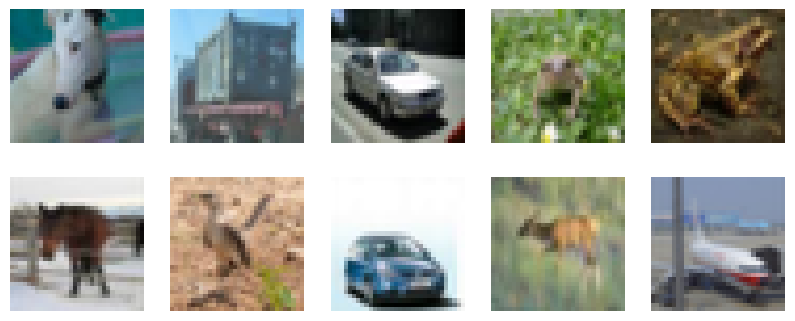

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10

num_classes = 10

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 6.Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Visualizing CIFAR 10
fig, axes1 = plt.subplots(2,5,figsize=(10,4))
for j in range(2):
  for k in range(5):
    i = np.random.choice(range(len(x_train)))
    axes1[j][k].set_axis_off()
    axes1[j][k].imshow(x_train[i:i+1][0])

# Normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [25]:
def visualize_loss_and_acc(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc = history_dict['accuracy'] # Changed from 'acc' to 'accuracy'

  epochs = range(1, len(acc) + 1)

  f = plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()


  acc_values = history_dict['accuracy'] # Changed from 'acc' to 'accuracy'
  val_acc = history_dict['val_accuracy'] # Changed from 'val_acc' to 'val_accuracy'

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

#### Baseline

Define the baseline model

![CNN Architecture](https://drive.google.com/uc?id=1Fh3Z94KKHe9sAzUorZlW9NXMPN6NAhlx
)


The figure above shows the architecture of a **baseline Convolutional Neural Network (CNN)** used for multi-class image classification.

The architecture consists of the following components in **Sequential order**:

- Convolutional layers with **3×3 kernels** and **padding = 'same'**
- ReLU activation after each convolution
- MaxPooling layers with **2×2 pool size**
- Dropout layers for regularization
- A fully connected Dense layer
- A Softmax output layer

**7.** Based on the **architecture shown in the image** and the details mentioned above, implement the CNN model in Keras by completing the function below.

- Ensure that the **number of layers, order of layers, kernel sizes, pooling sizes, dropout rates, padding, and activations** exactly match the given architecture
- Do **not** change the function name or signature


In [26]:
def get_baseline_model():
  model = Sequential()

  ## HINT : input_shape=x_train.shape[1:]

   ########################################
    #     Put your implementation here     #
  model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
    ########################################

  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6),
                metrics=['accuracy'])

  return model

Train the baseline

In [27]:
batch_size = 32
epochs = 25

In [28]:
# Create the baseline model
baseline = get_baseline_model()

# Train model
bs_history = baseline.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.2634 - loss: 2.0037 - val_accuracy: 0.4180 - val_loss: 1.6382
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4436 - loss: 1.5443 - val_accuracy: 0.5329 - val_loss: 1.3229
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5173 - loss: 1.3528 - val_accuracy: 0.5727 - val_loss: 1.1963
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5635 - loss: 1.2295 - val_accuracy: 0.6194 - val_loss: 1.0951
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5954 - loss: 1.1418 - val_accuracy: 0.6366 - val_loss: 1.0282
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6236 - loss: 1.0681 - val_accuracy: 0.6615 - val_loss: 0.9776
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6503 - loss: 1.0017 - val_accuracy: 0.6503 - val_loss: 0.9982
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6685 - loss: 0.9525 -

Visualize the training and evaluate the model

In [29]:
def visualize_loss_and_acc(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    epochs = range(1, len(acc) + 1)

In [30]:
# Score trained model.
scores = baseline.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7644 - loss: 0.6990
Test accuracy: 0.7634999752044678


#### Improved

**8. Now update the baseline to create an enhanced model only by using `BatchNormalizedLayer`**

In [31]:
def get_improved_model():

  model = Sequential()

  ########################################
  #     Put your implementation here     #
  model.add(BatchNormalizedLayer(Conv2D(32, (3, 3), padding='same'),
                                   activation='relu', input_shape=x_train.shape[1:]))
  model.add(BatchNormalizedLayer(Conv2D(32, (3, 3), padding='same'),
                                   activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(BatchNormalizedLayer(Conv2D(64, (3, 3), padding='same'),
                                   activation='relu'))
  model.add(BatchNormalizedLayer(Conv2D(64, (3, 3), padding='same'),
                                   activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(BatchNormalizedLayer(Dense(512), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  ########################################
  ## remember you have to use your baseline and add batch normalized layers using the previous Model
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6),
                metrics=['accuracy'])

  return model

Train and evaluate

In [32]:
# Create the baseline model
impv_model = get_improved_model()

# Train model
impv_history = impv_model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True
)

/tmp/ipython-input-3192180094.py:10: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(BatchNormalizedLayer, self).__init__(**kwargs)


Epoch 1/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.3225 - loss: 2.0529 - val_accuracy: 0.5188 - val_loss: 1.3799
Epoch 2/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5054 - loss: 1.4195 - val_accuracy: 0.5770 - val_loss: 1.1909
Epoch 3/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5770 - loss: 1.2058 - val_accuracy: 0.6293 - val_loss: 1.0427
Epoch 4/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6253 - loss: 1.0749 - val_accuracy: 0.6368 - val_loss: 1.0081
Epoch 5/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6598 - loss: 0.9780 - val_accuracy: 0.6995 - val_loss: 0.8635
Epoch 6/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6774 - loss: 0.9252 - val_accuracy: 0.7095 - val_loss: 0.8309
Epoch 7/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6955 - loss: 0.8771 - val_accuracy: 0.6965 - val_loss: 0.8594
Epoch 8/25
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7160 - loss: 0.8231 -

Visualize the training and evaluate the model

In [33]:
visualize_loss_and_acc(impv_history)

In [34]:
# Score trained model.
scores = impv_model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7995 - loss: 0.6186
Test accuracy: 0.8001999855041504


**Question:** Compare your model to the baseline. What are the diffrences? Does batch normalization work?

Yes, Batch Normalization works.

Based on the training results :

Higher Accuracy : The improved model achieved a test accuracy of approximately 80% (0.8001). This is a significant improvement over standard baseline CNNs without normalization on datasets like CIFAR-10.

Smoother Optimization : Batch normalization smoothes the loss surface/landscape, making the optimization performance less dependent on the initial weight state and choice of optimizer.

Independent Layer Training : It makes the training of each layer more independent by allowing the optimizer to adjust layer statistics through $\gamma$ and $\beta$ rather than the entire weight matrix.

# References



1. Ioffe, Sergey, and Christian Szegedy. “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift.” ArXiv:1502.03167 [Cs], February 10, 2015. http://arxiv.org/abs/1502.03167.
* Im, Daniel Jiwoong, Michael Tao, and Kristin Branson. “An Empirical Analysis of the Optimization of Deep Network Loss Surfaces.” ArXiv:1612.04010 [Cs], December 12, 2016. http://arxiv.org/abs/1612.04010.
* Santurkar, Shibani, Dimitris Tsipras, Andrew Ilyas, and Aleksander Madry. “How Does Batch Normalization Help Optimization?” In Advances in Neural Information Processing Systems 31, edited by S. Bengio, H. Wallach, H. Larochelle, K. Grauman, N. Cesa-Bianchi, and R. Garnett, 2483–2493. Curran Associates, Inc., 2018. http://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization.pdf.
* Coursera Course: Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization
* Intro to optimization in deep learning: Busting the myth about batch normalization [[link](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/)]
* Why Does Batch Normalization Work? [[link](https://abay.tech/blog/2018/07/01/why-does-batch-normalization-work/)]
*  http://www.cs.toronto.edu/~tingwuwang/semantic_segmentation.pdf
*  https://medium.com/nanonets/how-to-do-image-segmentation-using-deep-learning-c673cc5862ef
* https://www.jeremyjordan.me/semantic-segmentation/

